<h1 align="center">Volume 4: Inverse Problems.</h1>

    NAME
    Section #
    DATE

In [38]:
import numpy as np
from numpy.linalg import eigvals
from scipy.linalg import inv, solve_continuous_are
from matplotlib import pyplot as plt
from scipy.optimize import root
from scipy.integrate import odeint

# Problem 1

Write a function that returns the matrices A, B, Q, and R given above. Let
g = 9.8 m/s
2
.

In [30]:
def linearized_init(M, m, l, q1, q2, q3, q4, r):
    '''
    Parameters:
    ----------
    M, m: floats
          masses of the rickshaw and the present
    l   : float
          length of the rod
    q1, q2, q3, q4, r : floats
        relative weights of the position and velocity of the rickshaw, the
        angular displacement theta and the change in theta, and the control


    Return
    -------
    A : ndarray of shape (4,4)
    B : ndarray of shape (4,1)
    Q : ndarray of shape (4,4)
    R : ndarray of shape (1,1)
    '''
    g = 9.8
    A = np.array([[0, 1, 0, 0],
                  [0, 0, m*g/M, 0],
                  [0, 0, 0, 1],
                  [0, 0, g/(M*l) * (M + m), 0]])
    B = np.array([[0],
                  [1/M],
                  [0], 
                  [1/(M*l)]])
    Q = np.array([[q1, 0, 0, 0],
                  [0, q2, 0, 0],
                  [0, 0, q3, 0],
                  [0, 0, 0, q4]])
    R = np.array([[r]])
    return A, B, Q, R

# Problem 2

Write the following function to find the matrix P. Use scipy.optimize.root.
Since root takes in a vector and not a matrix, you will have to reshape the matrix P before
passing it in and after getting your result, using np.reshape(16) and np.reshape((4,4)).

In [31]:
def find_P(A,B,Q,R):
    '''
    Parameters:
    ----------
    A, B, Q : ndarrays of shape (4,4)
    R : ndarray of shape (1,1)
    
    Returns
    -------
    P : the matrix solution of the Riccati equation
    '''
    def f(P):
        P = np.reshape(P, (4,4))
        ans = P @ A + A.T @ P + Q - P@B@ inv(R) @ B.T @ P
        return np.reshape(ans, (16,))
    
    # Solve with scipy.optimize.root
    x0 = np.ones(16)
    sol = root(f, x0)
    return sol.x.reshape((4,4))

In [32]:
M, m = 23., 5.
l = 4.
q1, q2, q3, q4 = 1., 1., 1., 1.
r = 10.
g = 9.8

A, B, Q, R = linearized_init(M, m, l, q1, q2, q3, q4, r)
P = find_P(A, B, Q, R)

eigvals(A - B @ inv(R) @ B.T @ P)

array([-1.72875212+0.j        , -0.07538846+0.07490226j,
       -0.07538846-0.07490226j,  1.72530814+0.j        ])

# Problem 3
 
Write the following function that implements the LQR solution described earlier.
For the IVP solver, you can use your own or you may use the function odeint from scipy.
integrate.

In [35]:
def rickshaw(tv, X0, A, B, Q, R, P):
    '''
    Parameters:
    ----------
    tv : ndarray of time values, with shape (n+1,)
    X0 : Initial conditions on state variables
    A, Q: ndarrays of shape (4,4)
    B : ndarray of shape (4,1)
    R : ndarray of shape (1,1)
    P : ndarray of shape (4,4)
    Returns
    -------
    Z : ndarray of shape (n+1,4), the state vector at each time
    U : ndarray of shape (n+1,), the control values
    '''
    def f(x, t):
        return (A - B @ inv(R) @ B.T @ P) @ x
    # Solve using odeint
    sol = odeint(f, X0, tv)
    U = -inv(R)@B.T@P@sol.T
    return sol, U

# Problem 4

Test the function made in Problem (3). Find the matrix P using the scipy.optimize.root method with tf=6 as well as the solve_continuous_are
method with tf=60. Plot the solutions z˜ and u˜. Compare your results as shown in Figure
21.3.

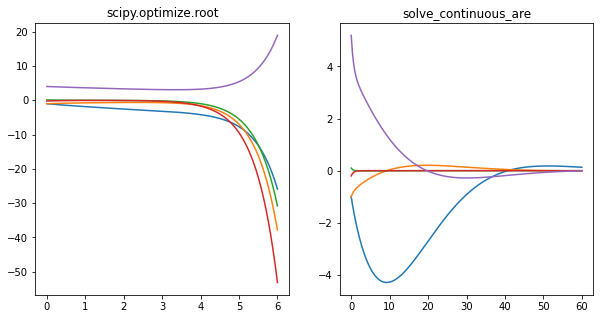

In [47]:
M, m = 23., 5.
l = 4.
q1, q2, q3, q4 = 1., 1., 1., 1.
r = 10.
tf_1 = 6
tv_1 = np.linspace(0, tf_1, 200)
tf_2 = 60
tv_2 = np.linspace(0, tf_2, 200)
X0 = np.array([-1, -1, .1, -.2])

# Find P different ways
A, B, Q, R = linearized_init(M, m, l, q1, q2, q3, q4, r)
P_1 = find_P(A, B, Q, R)
P_2 = solve_continuous_are(A, B, Q, R)

sol1, u1 = rickshaw(tv_1, X0, A, B, Q, R, P_1)
sol2, u2 = rickshaw(tv_2, X0, A, B, Q, R, P_2)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i in range(4):
    axs[0].plot(tv_1, sol1[:,i])
axs[0].plot(tv_1, u1.T)
axs[0].set_title('scipy.optimize.root')

for i in range(4):
    axs[1].plot(tv_2, sol2[:,i])
axs[1].plot(tv_2, u2.T)
axs[1].set_title('solve_continuous_are')
plt.show()